In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder

# Load data
data = pd.read_csv('../data/platinum/report_data.csv')

# Feature Engineering
# Skill Gap - calculate difference between userSkills and courseSkills
data['skill_gap'] = data.apply(lambda x: len(set(x['courseSkills']) - set(x['userSkills'])), axis=1)

# One-Hot Encoding for categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(data[['difficulty', 'language', 'progressStatus']]))
encoded_cols.columns = encoder.get_feature_names_out(['difficulty', 'language', 'progressStatus'])

# Concatenate encoded columns back into the dataset
data = pd.concat([data, encoded_cols], axis=1)

# Drop original categorical columns after encoding
data = data.drop(['difficulty', 'language', 'progressStatus'], axis=1)

# Inspect the new column names
print("Encoded columns: ", encoded_cols.columns)

# Prepare the features for modeling
X = data[['skill_gap', 'totalModules', 'totalTime', 'modulesCompleted'] + list(encoded_cols.columns)]  # Example features

# Use the correct one-hot encoded column for the target
y = encoded_cols['progressStatus_in_progress']  # Target column for in_progress courses

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

# Recommendation function
def recommend_courses(employee_id, data, model, encoded_cols):
    # Filter courses not completed by the employee
    employee_data = data[data['employeeId'] == employee_id]
    
    # Logic to identify completed courses
    incomplete_courses = employee_data[(encoded_cols['progressStatus_in_progress'] == 1) | 
                                       (encoded_cols['progressStatus_not_started'] == 1)]
    
    # Predict on available (incomplete) courses
    incomplete_courses['predicted_score'] = model.predict(incomplete_courses[['skill_gap', 'totalModules', 'totalTime', 'modulesCompleted'] + list(encoded_cols.columns)])
    
    # Sort by predicted score and remove duplicate courses by 'courseId'
    recommendations = incomplete_courses.sort_values(by='predicted_score', ascending=False).drop_duplicates(subset='courseId').head(5)
    
    return recommendations[['courseId', 'courseName']]

# Example recommendation for a specific employee
employee_id = 5  # Example employee ID
recommendations = recommend_courses(employee_id, data, model, encoded_cols)
print(recommendations)


Encoded columns:  Index(['difficulty_Beginner', 'difficulty_Intermediate', 'language_French',
       'language_German', 'language_Hindi', 'language_Japanese',
       'language_Spanish', 'language_Tamil', 'progressStatus_in_progress',
       'progressStatus_not_started'],
      dtype='object')
Accuracy: 1.0
Precision: 1.0
    courseId                                 courseName
13       110         Universal fault-tolerant emulation
17       231     Distributed leadingedge superstructure
23         1  Total solution-oriented Graphic Interface
22         3              Fundamental radical workforce


C:\Users\finda\AppData\Local\Temp\ipykernel_17040\1129572391.py:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  incomplete_courses = employee_data[(encoded_cols['progressStatus_in_progress'] == 1) |
C:\Users\finda\AppData\Local\Temp\ipykernel_17040\1129572391.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_courses['predicted_score'] = model.predict(incomplete_courses[['skill_gap', 'totalModules', 'totalTime', 'modulesCompleted'] + list(encoded_cols.columns)])


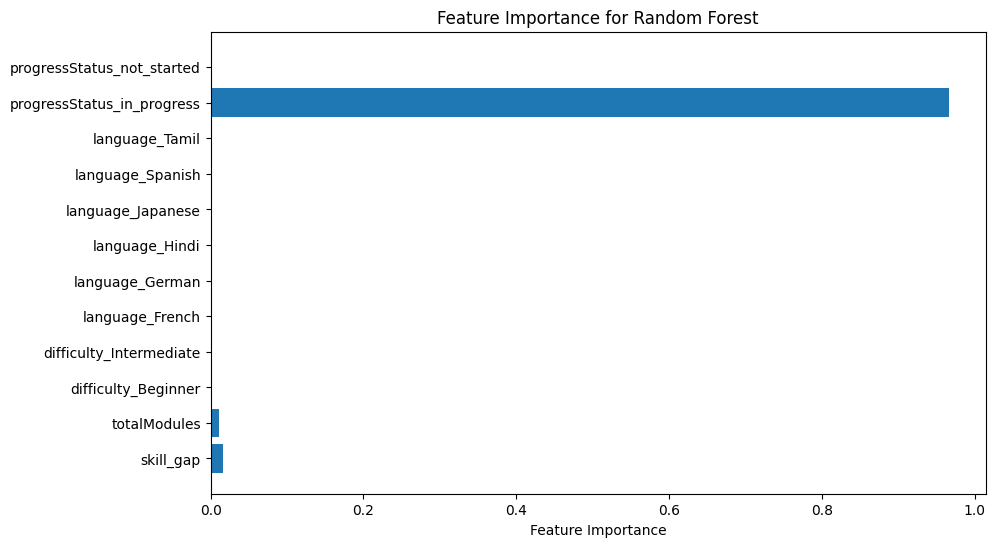

In [36]:
import matplotlib.pyplot as plt

rf_model = models['Random Forest']
importances = rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Random Forest')
plt.show()

In [40]:
pip install imblearn

   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/258.3 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------  256.0/258.3 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [106]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Load data
data = pd.read_csv('../data/platinum/report_data.csv')

# Preprocess the data
data['userSkills'] = data['userSkills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data['courseSkills'] = data['courseSkills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create a skills representation for each course
data['skills_vector'] = data['courseSkills'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the skills vector for courses
tfidf_matrix = tfidf_vectorizer.fit_transform(data['skills_vector'])

# Create a function to recommend courses based on employee skills
def recommend_courses_content_based(employee_id, data, top_n=5):
    # Get the employee's skills
    employee_data = data[data['employeeId'] == employee_id]
    
    if employee_data.empty:
        return f"No data found for employee ID: {employee_id}"
    
    # Assuming we take the first entry for the employee's skills
    employee_skills = employee_data.iloc[0]['userSkills']
    employee_skills_vector = ' '.join(employee_skills)

    # Transform the employee skills into TF-IDF representation
    employee_tfidf = tfidf_vectorizer.transform([employee_skills_vector])

    # Calculate cosine similarity
    cosine_sim = cosine_similarity(employee_tfidf, tfidf_matrix)

    # Get similarity scores for the employee against all courses
    scores = cosine_sim[0]  # Scores are in the first row

    # Add scores to the DataFrame
    data['similarity_score'] = scores

    # Filter out courses already taken
    completed_courses = employee_data['courseId'].unique()
    filtered_data = data[~data['courseId'].isin(completed_courses)]
    filtered_data_unique = filtered_data.drop_duplicates(subset='courseId')

    # Recommend courses based on highest similarity scores
    recommendations = filtered_data_unique.nlargest(top_n, 'similarity_score')

    return recommendations[['courseId', 'courseName', 'similarity_score']]

# Example recommendation for a specific employee
employee_id = 15  # Example employee ID
recommendations = recommend_courses_content_based(employee_id, data)
print(recommendations)


      courseId                             courseName  similarity_score
968        215            Reduced multimedia extranet          0.453229
621        345       Upgradable uniform knowledgebase          0.408458
734        116  User-friendly fault-tolerant attitude          0.381977
366        177    Fundamental demand-driven framework          0.348676
1012       175     Centralized incremental task-force          0.310925


content based with ml

In [131]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast

# Load data
data = pd.read_csv('../data/platinum/report_data.csv')

# Preprocess the data
data['userSkills'] = data['userSkills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data['courseSkills'] = data['courseSkills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create a skills representation for each course
data['skills_vector'] = data['courseSkills'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['skills_vector'])

# Prepare data for machine learning model
features = []
for index, row in data.iterrows():
    for skill in row['userSkills']:
        features.append({'employeeId': row['employeeId'], 'courseId': row['courseId'], 'skill': skill})

features_df = pd.DataFrame(features)

# Encode courseId and employeeId
label_encoder = LabelEncoder()
features_df['courseId'] = label_encoder.fit_transform(features_df['courseId'])
features_df['employeeId'] = label_encoder.fit_transform(features_df['employeeId'])

# Create the target variable (1 if course was taken, 0 otherwise)
features_df['target'] = 1  # Mark taken courses as 1
taken_courses = set(zip(data['employeeId'], data['courseId']))

# Fill in the 0s for courses that were not taken
missing_rows = []
for employee_id in features_df['employeeId'].unique():
    for course_id in label_encoder.classes_:
        if (employee_id, course_id) not in taken_courses:
            missing_rows.append({'employeeId': employee_id, 'courseId': course_id, 'skill': None, 'target': 0})

missing_df = pd.DataFrame(missing_rows)
features_df = pd.concat([features_df, missing_df], ignore_index=True)

# Sample a fraction of the data
features_df = features_df.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Split data into training and testing sets
X = features_df[['employeeId', 'courseId']]
y = features_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model with class weights
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define parameter grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best model from Randomized Search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Function to recommend unique courses based on ML predictions
def recommend_courses_ml(employee_id, data, model, top_n=5):
    possible_courses = data['courseId'].unique()
    predictions = []

    for course in possible_courses:
        input_data = pd.DataFrame({'employeeId': [employee_id], 'courseId': [course]})
        prediction = model.predict(input_data)
        predictions.append((course, prediction[0]))

    predicted_df = pd.DataFrame(predictions, columns=['courseId', 'predicted'])
    recommended_courses = predicted_df[predicted_df['predicted'] == 1]
    recommended_courses = recommended_courses.merge(data[['courseId', 'courseName']], on='courseId', how='left')
    unique_courses = recommended_courses.drop_duplicates(subset='courseId').nlargest(top_n, 'predicted')

    return unique_courses[['courseId', 'courseName']]

# Example recommendation for a specific employee
employee_id = 20  # Example employee ID
recommended_courses = recommend_courses_ml(employee_id, data, best_model)
print(recommended_courses)


Accuracy: 0.96
Precision: 0.84
Recall: 0.94
F1 Score: 0.89
    courseId                                       courseName
0        119                      Secured interactive product
7          1        Total solution-oriented Graphic Interface
16       121                  Realigned multimedia neural-net
24       122                    Right-sized web-enabled array
43       123  Fully-configurable multi-tasking infrastructure


In [134]:
# Function to recommend unique courses based on ML predictions
def recommend_courses_ml(employee_id, data, model, top_n=5):
    possible_courses = data['courseId'].unique()
    predictions = []

    for course in possible_courses:
        input_data = pd.DataFrame({'employeeId': [employee_id], 'courseId': [course]})
        prediction = model.predict(input_data)
        predictions.append((course, prediction[0]))

    predicted_df = pd.DataFrame(predictions, columns=['courseId', 'predicted'])
    recommended_courses = predicted_df[predicted_df['predicted'] == 1]
    recommended_courses = recommended_courses.merge(data[['courseId', 'courseName']], on='courseId', how='left')
    unique_courses = recommended_courses.drop_duplicates(subset='courseId').nlargest(top_n, 'predicted')

    return unique_courses[['courseId', 'courseName']]

# Example recommendation for a specific employee
employee_id = 7  # Example employee ID
recommended_courses = recommend_courses_ml(employee_id, data, best_model)
print(recommended_courses)

    courseId                                 courseName
0          1  Total solution-oriented Graphic Interface
9        197        Seamless client-server architecture
23         7               Focused optimal secured line
28       321       Self-enabling interactive neural-net
36       204      Stand-alone multimedia knowledge user


In [135]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast

# Load data
data = pd.read_csv('../data/platinum/report_data.csv')

# Preprocess the data
data['userSkills'] = data['userSkills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
data['courseSkills'] = data['courseSkills'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Create a skills representation for each course
data['skills_vector'] = data['courseSkills'].apply(lambda x: ' '.join(x))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['skills_vector'])

# Prepare data for machine learning model
features = []
for index, row in data.iterrows():
    for skill in row['userSkills']:
        features.append({'employeeId': row['employeeId'], 'courseId': row['courseId'], 'skill': skill})

features_df = pd.DataFrame(features)

# Encode courseId and employeeId
label_encoder = LabelEncoder()
features_df['courseId'] = label_encoder.fit_transform(features_df['courseId'])
features_df['employeeId'] = label_encoder.fit_transform(features_df['employeeId'])

# Create the target variable (1 if course was taken, 0 otherwise)
features_df['target'] = 1  # Mark taken courses as 1
taken_courses = set(zip(data['employeeId'], data['courseId']))

# Fill in the 0s for courses that were not taken
missing_rows = []
for employee_id in features_df['employeeId'].unique():
    for course_id in label_encoder.classes_:
        if (employee_id, course_id) not in taken_courses:
            missing_rows.append({'employeeId': employee_id, 'courseId': course_id, 'skill': None, 'target': 0})

missing_df = pd.DataFrame(missing_rows)
features_df = pd.concat([features_df, missing_df], ignore_index=True)

# Sample a fraction of the data
features_df = features_df.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Split data into training and testing sets
X = features_df[['employeeId', 'courseId']]
y = features_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model with class weights
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define parameter grid for Randomized Search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best model from Randomized Search
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Function to recommend unique courses based on ML predictions
def recommend_courses_ml(employee_id, data, model, top_n=5):
    possible_courses = data['courseId'].unique()
    predictions = []

    for course in possible_courses:
        input_data = pd.DataFrame({'employeeId': [employee_id], 'courseId': [course]})
        prediction = model.predict(input_data)
        predictions.append((course, prediction[0]))

    predicted_df = pd.DataFrame(predictions, columns=['courseId', 'predicted'])
    recommended_courses = predicted_df[predicted_df['predicted'] == 1]
    recommended_courses = recommended_courses.merge(data[['courseId', 'courseName']], on='courseId', how='left')
    unique_courses = recommended_courses.drop_duplicates(subset='courseId').nlargest(top_n, 'predicted')

    return unique_courses[['courseId', 'courseName']]

# Example recommendation for a specific employee
employee_id = 20  # Example employee ID
recommended_courses = recommend_courses_ml(employee_id, data, best_model)
print(recommended_courses)


Accuracy: 0.96
Precision: 0.84
Recall: 0.94
F1 Score: 0.89
    courseId                                       courseName
0        119                      Secured interactive product
7          1        Total solution-oriented Graphic Interface
16       121                  Realigned multimedia neural-net
24       122                    Right-sized web-enabled array
43       123  Fully-configurable multi-tasking infrastructure


  Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached wheel-0.44.0-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 435.7 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.8 MB 544.7 kB/s eta 0:00:04
   ----- ---------------------------------- 0.3/1.8 MB 1.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.6/1.8 MB 3.0 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.8 MB 4.1 MB/s eta 0:00:01
   ------------------------------ --------- 1.4/1.8 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  1.8/1.8 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 5.2 MB/s eta 0:00:00
Using cached setuptools-75.1.0-py3-none-any.whl (1.2 MB)
Using cached wheel-0.44.0-py3-none-any.whl (67 kB)
  Attemptin